In [15]:
import matplotlib.pyplot as plt
def plotLoss(losses):
    plt.figure(dpi=90)
    plt.plot(losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, learning_rate):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),     
            nn.Linear(512, 256),
            nn.ReLU(),     
            nn.Linear(256, 128),
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)


    def forward(self, x):
        x = self.layers(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, learning_rate):
        super(Decoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),     
            nn.Linear(256, 512),  
            nn.ReLU(),     
            nn.Linear(512, 784),  
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.layers(x)
        return x
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [3]:
def flatten(tensor):
    return tensor.view(-1)

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(torch.flatten)
])

batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [28]:

learning_rate = 0.001
epochs = 10



encoder = Encoder(learning_rate).to(device)
decoder = Decoder(learning_rate).to(device)
criterion = nn.MSELoss()

losses = []

for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, _ = data

        images = images.to(device)

        encoder.zero_grad()
        decoder.zero_grad()
        
        encodedImages = encoder(images)
        outputs = decoder(encodedImages)

        loss = criterion(outputs, images)

        loss.backward()
        losses.append(loss.item())
        encoder.optimizer.step()
        decoder.optimizer.step()

    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


torch.save(encoder.state_dict(), 'mnist_autoencoder_cnn.pth')
torch.save(decoder.state_dict(), 'mnist_autoencoder_cnn.pth')

100%|██████████| 938/938 [00:04<00:00, 223.85it/s]


Epoch [1/10], Loss: 0.0290


100%|██████████| 938/938 [00:04<00:00, 225.42it/s]


Epoch [2/10], Loss: 0.0243


100%|██████████| 938/938 [00:04<00:00, 223.76it/s]


Epoch [3/10], Loss: 0.0143


100%|██████████| 938/938 [00:04<00:00, 219.12it/s]


Epoch [4/10], Loss: 0.0148


100%|██████████| 938/938 [00:04<00:00, 220.43it/s]


Epoch [5/10], Loss: 0.0141


100%|██████████| 938/938 [00:04<00:00, 218.25it/s]


Epoch [6/10], Loss: 0.0161


100%|██████████| 938/938 [00:04<00:00, 221.47it/s]


Epoch [7/10], Loss: 0.0105


100%|██████████| 938/938 [00:04<00:00, 215.81it/s]


Epoch [8/10], Loss: 0.0089


100%|██████████| 938/938 [00:04<00:00, 224.15it/s]


Epoch [9/10], Loss: 0.0077


100%|██████████| 938/938 [00:04<00:00, 226.82it/s]

Epoch [10/10], Loss: 0.0091


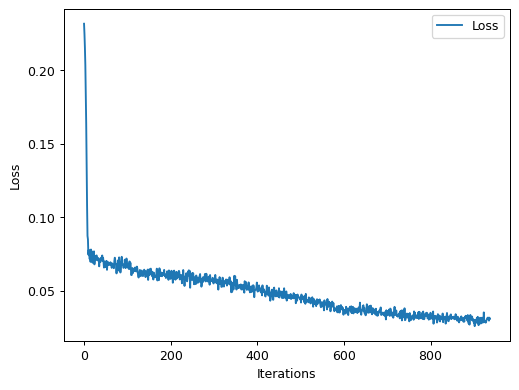

In [27]:
plotLoss(losses)

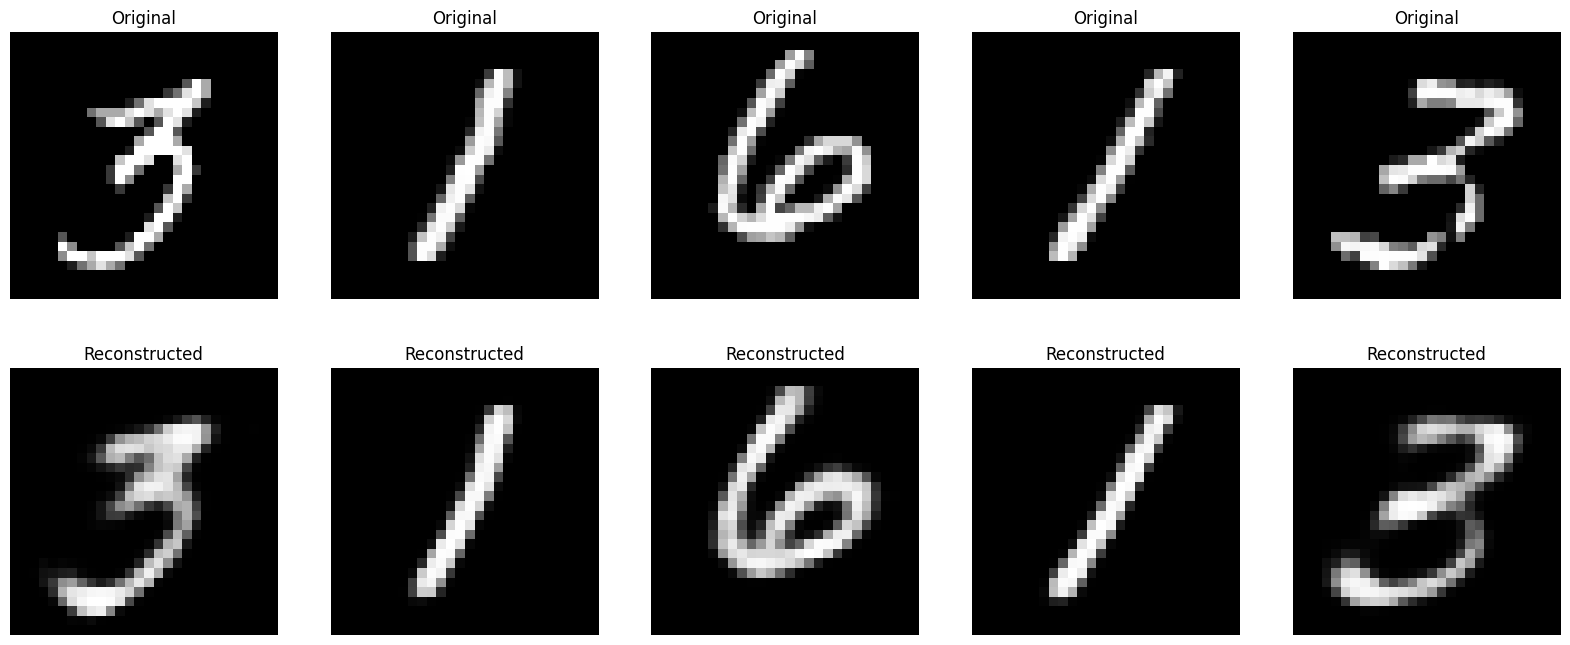

In [29]:
import matplotlib.pyplot as plt
def displayAutoencoder(original, reconstructed, n=5):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].numpy().squeeze().reshape(28,28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].detach().numpy().squeeze().reshape(28,28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

def displayImages(original, n=5):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].numpy().squeeze().reshape(28,28), cmap='gray')
        plt.title('Original')
        plt.axis('off')
    plt.show()

with torch.no_grad():
    
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)
    reconstructed_images = decoder(encoder(test_images))
    displayAutoencoder(test_images.cpu(), reconstructed_images.cpu())

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
class Denoiser(nn.Module):
    def __init__(self, learning_rate):
        super(Denoiser, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),     
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    def forward(self, x):
        x = self.layers(x)
        return x

In [43]:
import numpy as np
learning_rate = 0.001
epochs = 10
denoiser = Denoiser(learning_rate).to(device)
criterion = nn.BCELoss()
losses = []
def one_hot_encode(labels):
    
    num_classes = 10
    
    
    onehot_labels = torch.zeros((labels.shape[0], num_classes)).to(labels.device)
    
    
    onehot_labels.scatter_(1, labels.unsqueeze(1), 1)
    
    return onehot_labels.to(device)
for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, labels = data
        oneHotLabels = one_hot_encode(labels)
        images = images.to(device)
        denoiser.optimizer.zero_grad()
        
        encoded = encoder(images)
        noise = torch.randn_like(encoded)  * 0.5
        predicted = denoiser(torch.sigmoid(encoded+noise))
        loss = criterion(predicted, encoded)
        loss.backward()
        losses.append(loss.item())
        denoiser.optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    
torch.save(denoiser.state_dict(), 'mnist_gan_discriminator.pth')

100%|██████████| 938/938 [00:04<00:00, 213.74it/s]


Epoch [1/10], Loss: 0.4957


100%|██████████| 938/938 [00:04<00:00, 210.38it/s]


Epoch [2/10], Loss: 0.4795


100%|██████████| 938/938 [00:04<00:00, 206.42it/s]


Epoch [3/10], Loss: 0.4630


100%|██████████| 938/938 [00:04<00:00, 219.63it/s]


Epoch [4/10], Loss: 0.4527


100%|██████████| 938/938 [00:04<00:00, 223.89it/s]


Epoch [5/10], Loss: 0.4642


100%|██████████| 938/938 [00:04<00:00, 223.05it/s]


Epoch [6/10], Loss: 0.4567


100%|██████████| 938/938 [00:04<00:00, 216.65it/s]


Epoch [7/10], Loss: 0.4689


100%|██████████| 938/938 [00:04<00:00, 224.20it/s]


Epoch [8/10], Loss: 0.4403


100%|██████████| 938/938 [00:04<00:00, 224.25it/s]


Epoch [9/10], Loss: 0.4510


100%|██████████| 938/938 [00:04<00:00, 214.76it/s]

Epoch [10/10], Loss: 0.4608


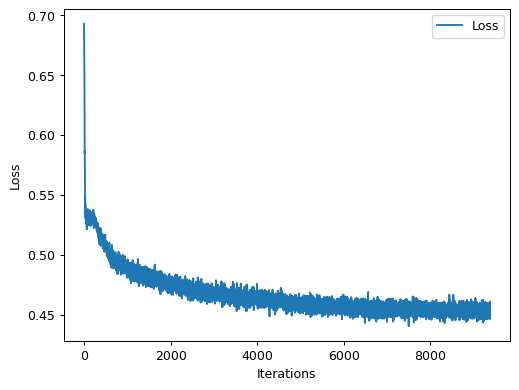

In [44]:
import matplotlib.pyplot as plt
plt.figure(dpi=90)
plt.plot(losses, label='Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

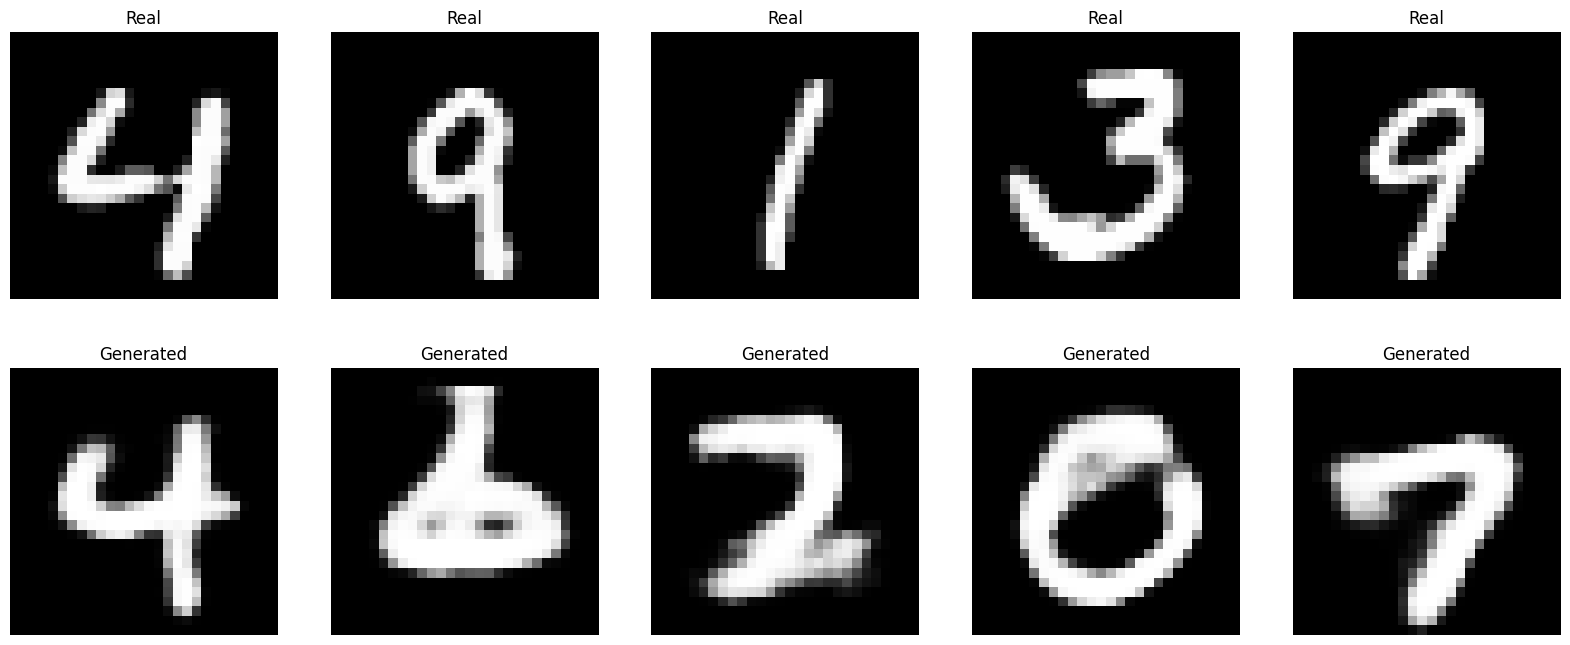

In [53]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, n=5):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].numpy().reshape((28,28)).squeeze(), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].detach().numpy().reshape((28,28)).squeeze(), cmap='gray')
        plt.title('Generated')
        plt.axis('off')
    
    plt.show()
    


def displayExamples():
    fakeInput = torch.randn((5, 128), device=device)
    with torch.no_grad():
        
        test_images, _ = next(iter(train_loader))
        test_images = test_images.to(device)

        

        out = fakeInput
        for i in range(10):
            out = denoiser(out)

        reconstructed_images = decoder(out)

        
        show_images(test_images.cpu(), reconstructed_images.cpu())

displayExamples()